In [4]:
import duckdb
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

## Step 0: Importing all the AIDev dataset

In [5]:
pr = pd.read_parquet("all_pull_request.parquet")
#print(pr)
user = pd.read_parquet("all_user.parquet")
pr_comments = pd.read_parquet("pr_comments.parquet")
pr_reviews = pd.read_parquet("pr_reviews.parquet")
pr_review_comments = pd.read_parquet("pr_review_comments.parquet")
repo = pd.read_parquet("all_repository.parquet")
#print(repo)
timeline = pd.read_parquet("pr_timeline.parquet")
print(repo.head())

           id                                                url license  \
0   987641962  https://api.github.com/repos/1010-dev/senjudev...    None   
1   990249393  https://api.github.com/repos/106-/HellSinkerWa...    None   
2  1009549206  https://api.github.com/repos/1genadam/tileshop...    None   
3   983546765  https://api.github.com/repos/1kimnet/ETL-pipeline    None   
4  1024190983  https://api.github.com/repos/20m61/lightningta...    None   

                    full_name    language  forks  stars  
0      1010-dev/senjudev-site  TypeScript    1.0    0.0  
1    106-/HellSinkerWallPaper        Java    0.0    0.0  
2       1genadam/tileshop-rag      Python    0.0    0.0  
3        1kimnet/ETL-pipeline      Python    0.0    0.0  
4  20m61/lightningtalk-circle  JavaScript    0.0    0.0  


## Step 1: Build the Agent–Repo Co-occurrence Matrix to check out the data structure

              Claude_Code  Copilot  Cursor  Devin  OpenAI_Codex
Claude_Code             0       72      72     47           189
Copilot                72        0     156     74           702
Cursor                 72      156       0     84           646
Devin                  47       74      84      0           247
OpenAI_Codex          189      702     646    247             0


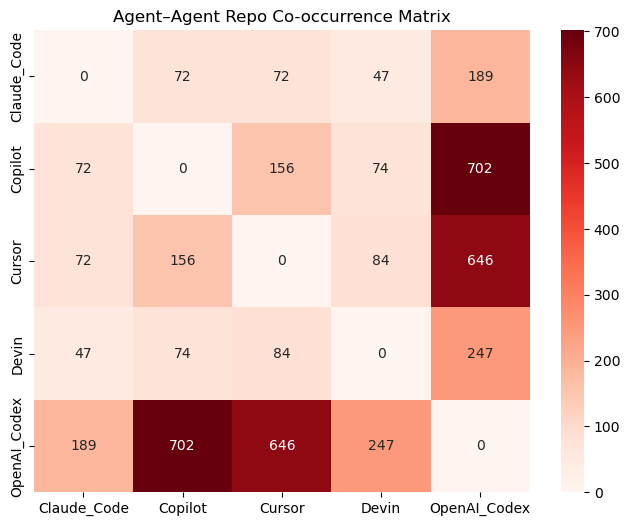

In [6]:
df_conn= pr[["repo_id", "agent"]].dropna()
df = df_conn.drop_duplicates()
agents = sorted(df["agent"].unique())
overlap = pd.DataFrame(0, index=agents, columns=agents)

agent_repo = {}

for ag in agents:
    repos = df[df.agent == ag]["repo_id"].unique()
    repo_set = set(repos)
    agent_repo[ag] = repo_set

# 两两计算交集
for a, b in itertools.combinations(agents, 2):
    shared = agent_repo[a] & agent_repo[b]
    overlap.loc[a, b] = len(shared)
    overlap.loc[b, a] = len(shared)

print(overlap)
#热力图
plt.figure(figsize=(8,6))
sns.heatmap(overlap, annot=True, fmt="d", cmap="Reds")
plt.title("Agent–Agent Repo Co-occurrence Matrix")
plt.show()



## Step2: Data Cleaning and Feature Construction
We cleaned the PR dataset and created several repository-level features for analysis. 

From grouped PR records, we computed the total number of pull requests (pr_count), the merge rate (merge_rate), the number of unique contributors (contributors), the average review comments (review_density), and the average merge time (merge_time). 

We also identified the dominant agent in each repository. All these fields, were merged into the main repository table to arrive at complete repo_activity dataset for further analysis.

In [7]:
### Step2.1:

In [8]:

pr_count = pr.groupby("repo_id").size().rename("pr_count")
pr_count.sort_values(ascending=False).head(3)

repo_id
9.858531e+08    8913
9.964551e+08    4436
1.021905e+09    3740
Name: pr_count, dtype: int64

In [9]:
#merge rate
merge_rate = (pr["merged_at"].notna()).groupby(pr["repo_id"]).mean().rename("merge_rate")
merge_rate.sort_values(ascending=False)

repo_id
2.727000e+03    1.0
9.979159e+08    1.0
9.979192e+08    1.0
9.979186e+08    1.0
9.979171e+08    1.0
               ... 
5.866988e+08    0.0
8.923006e+08    0.0
8.922621e+08    0.0
9.975190e+08    0.0
1.003096e+09    0.0
Name: merge_rate, Length: 116211, dtype: float64

In [10]:
pr["created_at"] = pd.to_datetime(pr["created_at"], errors="coerce")
pr["merged_at"] = pd.to_datetime(pr["merged_at"], errors="coerce")


merged_pr = pr[pr["merged_at"].notna()].copy()

merged_pr["merge_time"] = ((merged_pr["merged_at"] - merged_pr["created_at"]).dt.total_seconds() / 3600)

merged_pr = merged_pr[merged_pr["merge_time"] >= 0]

repo_merge_time = (merged_pr.groupby("repo_id")["merge_time"].mean().rename("avg_merge_time"))
print(repo_merge_time.head())


repo_id
2727.0     12.902222
3542.0      3.443611
6675.0      0.027315
33509.0    24.665833
37370.0     0.107778
Name: avg_merge_time, dtype: float64


In [11]:
#Contributors
contributors = pr.groupby("repo_id")["user_id"].nunique().rename("contributors")
contributors.sort_values(ascending=False).head()

repo_id
873328.0       24
33837371.0     21
965415649.0    12
952238700.0    11
440752086.0     8
Name: contributors, dtype: int64

In [12]:
#review_comment_count
 
review_comment_count = (pr_review_comments.groupby("pull_request_review_id").size().rename("review_comment_count"))
tmp_reviews = pr_reviews[["id", "pr_id"]].merge(review_comment_count,left_on="id",right_index=True,
how="left")

# merge to PR，sum results per repo 
tmp = pr[["id", "repo_id"]].merge(tmp_reviews, left_on="id", right_on="pr_id",how="left")
review_density_repo = tmp.groupby("repo_id")["review_comment_count"].sum().rename("review_density")
print(review_density_repo.sort_values(ascending=False).head())

repo_id
696529789.0    670.0
2928944.0      483.0
210716005.0    443.0
65080725.0     434.0
839216423.0    364.0
Name: review_density, dtype: float64


### Another method ( SQL )to make sure the aggregation is correct

In [13]:
# the same as the above results
query = """
SELECT 
    pr.repo_id,
    COUNT(rc.id) AS review_comment_count
FROM pr_review_comments rc
JOIN pr_reviews r
    ON rc.pull_request_review_id = r.id
JOIN 'all_pull_request.parquet' pr
    ON r.pr_id = pr.id
GROUP BY pr.repo_id
ORDER BY review_comment_count DESC;
"""

repo_stats = duckdb.query(query).to_df()
repo_stats.head()

,repo_id,review_comment_count
0,696529789.0,670
1,2928944.0,483
2,210716005.0,443
3,65080725.0,434
4,839216423.0,364


In [14]:
repo_activity = (
    repo
    .merge(pr_count.rename("pr_count"), left_on="id", right_index=True, how="left")
    .merge(merge_rate.rename("merge_rate"), left_on="id", right_index=True, how="left")
    .merge(contributors.rename("contributors"), left_on="id", right_index=True, how="left")
    .merge(review_density_repo.rename("review_density"), left_on="id", right_index=True, how="left")
    .merge(repo_merge_time.rename("merge_time"), left_on="id", right_index=True, how="left")
)

repo_activity = repo_activity.fillna(0)
repo_activity.head()


,id,url,license,full_name,language,forks,stars,pr_count,merge_rate,contributors,review_density,merge_time
0,987641962,https://api.github.com/repos/1010-dev/senjudev...,0,1010-dev/senjudev-site,TypeScript,1.0,0.0,1,1.000000,1,0.0,572.567222
1,990249393,https://api.github.com/repos/106-/HellSinkerWa...,0,106-/HellSinkerWallPaper,Java,0.0,0.0,2,1.000000,1,0.0,0.147500
2,1009549206,https://api.github.com/repos/1genadam/tileshop...,0,1genadam/tileshop-rag,Python,0.0,0.0,1,1.000000,1,0.0,0.048889
3,983546765,https://api.github.com/repos/1kimnet/ETL-pipeline,0,1kimnet/ETL-pipeline,Python,0.0,0.0,37,0.432432,2,0.0,11.230382
4,1024190983,https://api.github.com/repos/20m61/lightningta...,0,20m61/lightningtalk-circle,JavaScript,0.0,0.0,7,0.857143,1,0.0,2.547454


In [15]:
agent_count = (
    pr.groupby(["repo_id", "agent"]).size()
      .reset_index(name="agent_pr_count")
)

dominant_agent = (
    agent_count.loc[
        agent_count.groupby("repo_id")["agent_pr_count"].idxmax()
    ][["repo_id", "agent"]]
).rename(columns={"agent": "dominate_agent"})
print(dominant_agent)
dominant_agent = dominant_agent.rename(columns={"repo_id": "id"})

repo_activity = repo_activity.merge(dominant_agent, on="id", how="left")


             repo_id dominate_agent
0       2.727000e+03        Copilot
1       3.542000e+03   OpenAI_Codex
2       6.675000e+03   OpenAI_Codex
3       3.350900e+04        Copilot
4       3.737000e+04   OpenAI_Codex
...              ...            ...
118336  1.029709e+09        Copilot
118337  1.029747e+09   OpenAI_Codex
118338  1.029788e+09   OpenAI_Codex
118339  1.029801e+09   OpenAI_Codex
118340  1.029817e+09   OpenAI_Codex

[116211 rows x 2 columns]


## Step3:Constructed two composite metrics—Efficiency and Popularity—based on transformed versions of the raw fields.

To reduce skewness and handle large ranges, we applied a log_scale function to normalize variables such as PR count, number of contributors, and review density.

For merge performance, we created a merge_rate_score by scaling the merge rate to a 0–100 range, and computed a merge_time_score using a custom function that removes extreme outliers, applies a log transform, and assigns higher scores to faster merges. 

The final Efficiency metric combines these two components with weights of 0.6 for merge rate and 0.4 for merge time. Similarly, a weighted Popularity index was created using log-scaled PR volume, contributor count, and review activity (70%, 10%, and 20% respectively). All results were appended to the repo_activity table and exported as repo_activity.csv for downstream analysis.


In [17]:
from scipy.stats import norm

def log_scale(series):
    s = series.copy()
    s_log = np.log1p(s)   # log(1+x)
    return 100 * (s_log - s_log.min()) / (s_log.max() - s_log.min())

import numpy as np
import pandas as pd

def compute_merge_time_score(df, time_col="merge_time", rate_col="merge_rate_score",
                                        rate_threshold=30, outlier_pct=0.03):
    
    mt = df[time_col].astype(float)
    rate = df[rate_col].astype(float)

    n = len(mt)
    k = max(1, int(np.ceil(n * outlier_pct)))   
    cutoff = mt.nlargest(k).min()               

    score = pd.Series(np.zeros(n), index=df.index)

    valid_mask = (rate >= rate_threshold) & (mt < cutoff)
    valid_mt = mt[valid_mask]

    log_mt = np.log(valid_mt + 1)
    log_min = log_mt.min()
    log_max = log_mt.max()

    score_valid = 100 * (log_max - log_mt) / (log_max - log_min)
    score.loc[valid_mask] = score_valid

    score = score.clip(lower=0, upper=100)

    return score


repo_activity["merge_rate_score"] = repo_activity["merge_rate"]*100
repo_activity["merge_time_score"] = compute_merge_time_score(repo_activity,"merge_time","merge_rate_score")

#repo_activity["throughput_score"] = log_scale(repo_activity["throughput"])

# Final Efficiency（
repo_activity["Efficiency"] = (
    0.6 * repo_activity["merge_rate_score"]
    + 0.4 * repo_activity["merge_time_score"]
)



In [22]:
repo_activity["pr_count_score"] = log_scale(repo_activity["pr_count"])
repo_activity["contributors_score"] = log_scale(repo_activity["contributors"])
repo_activity["review_comment_score"] = log_scale(repo_activity["review_density"])


# Final Popularity
repo_activity["Popularity"] = (
    0.70 * repo_activity["pr_count_score"]
    + 0.10 * repo_activity["contributors_score"]
    + 0.20 * repo_activity["review_comment_score"]
)
print(repo_activity.head())
repo_activity.to_csv("repo_activity.csv", index=False)

           id                                                url license  \
0   987641962  https://api.github.com/repos/1010-dev/senjudev...       0   
1   990249393  https://api.github.com/repos/106-/HellSinkerWa...       0   
2  1009549206  https://api.github.com/repos/1genadam/tileshop...       0   
3   983546765  https://api.github.com/repos/1kimnet/ETL-pipeline       0   
4  1024190983  https://api.github.com/repos/20m61/lightningta...       0   

                    full_name    language  forks  stars  pr_count  merge_rate  \
0      1010-dev/senjudev-site  TypeScript    1.0    0.0         1    1.000000   
1    106-/HellSinkerWallPaper        Java    0.0    0.0         2    1.000000   
2       1genadam/tileshop-rag      Python    0.0    0.0         1    1.000000   
3        1kimnet/ETL-pipeline      Python    0.0    0.0        37    0.432432   
4  20m61/lightningtalk-circle  JavaScript    0.0    0.0         7    0.857143   

   contributors  ...  merge_time  dominate_agent merge_r

## Step4:Understand the overall landscape of repository behavior

We applied three methods to reduce the efficiency- and popularity-related features into two principal components. This transformation preserves the most important variation in the data while enabling a clear 2-D visualization. 

We plotted the KMeans cluster assignments to show how repositories group together based on their activity and performance profiles. 

The resulting scatter plot provides an intuitive view of the distribution and separation of repository clusters, helping reveal major behavioral patterns across the ecosystem.

## The cleaning and understanding of the dataset is completed.

In [19]:
features = repo_activity[["pr_count", "merge_rate", "contributors", "review_density"]].fillna(0)

X = repo_activity[["Efficiency", "Popularity"]].values


In [20]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X)
print(X.shape)

repo_activity["cluster"] = cluster_labels


(116211, 2)


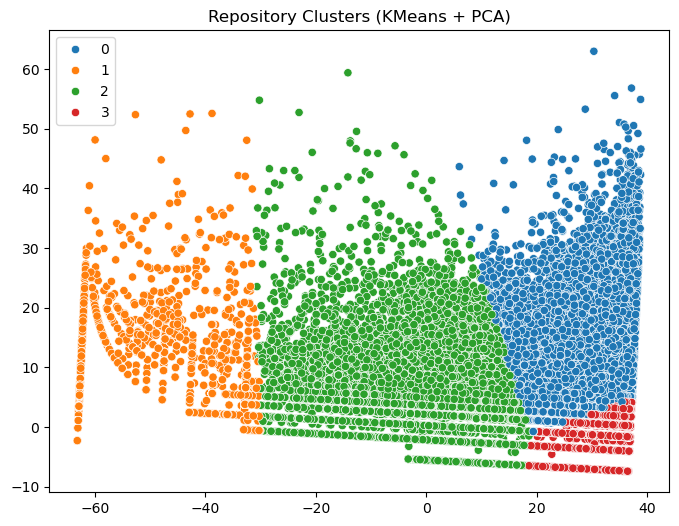

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
coords = pca.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=cluster_labels, palette="tab10")
plt.title("Repository Clusters (KMeans + PCA)")
plt.show()


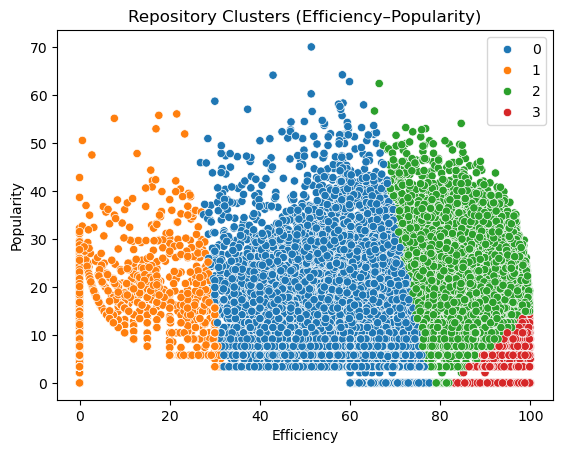

In [134]:
sns.scatterplot(
    data=repo_activity,
    x="Efficiency",
    y="Popularity",
    hue=cluster_labels,
    palette="tab10"
)
plt.title("Repository Clusters (Efficiency–Popularity)")
plt.show()

In [132]:
centers = kmeans.cluster_centers_
print(pd.DataFrame(centers, columns=["Efficiency", "Popularity"]))


   Efficiency  Popularity
0   61.925087   10.271458
1    0.825577    1.750609
2   87.549595   15.825484
3   98.752835    2.608216


/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


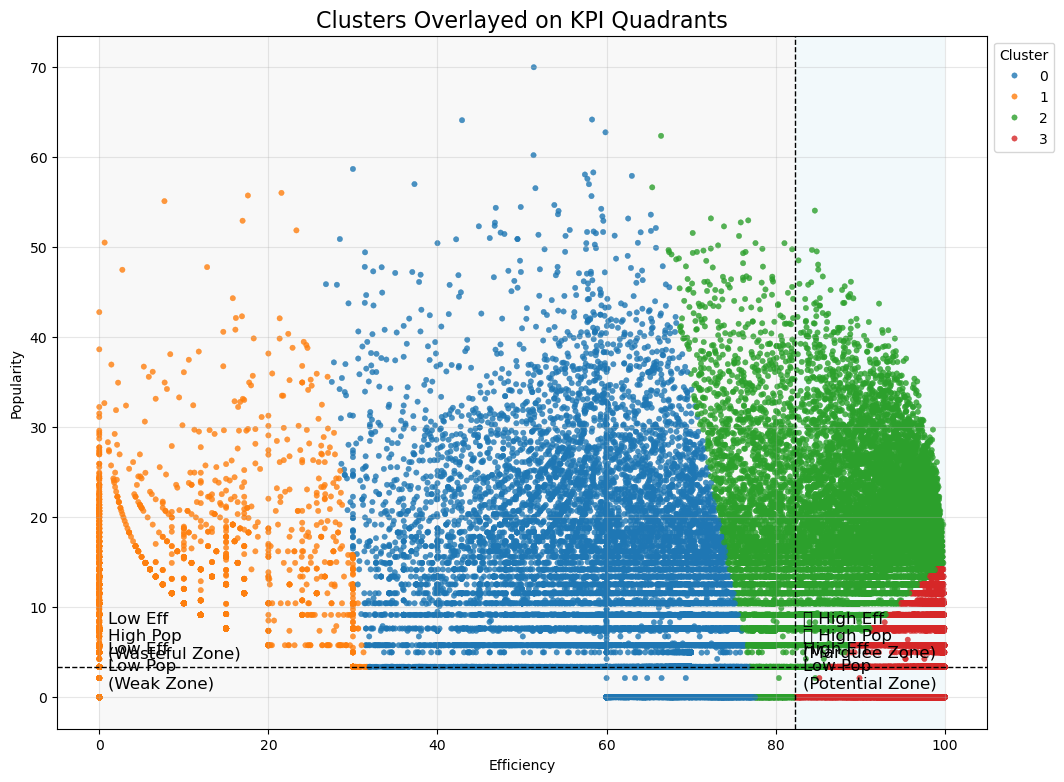

In [133]:
import seaborn as sns

eff_threshold = repo_activity["Efficiency"].median()
pop_threshold = repo_activity["Popularity"].median()

plt.figure(figsize=(12, 9))

plt.axvspan(
    repo_activity["Efficiency"].min(), eff_threshold,
    repo_activity["Popularity"].min(), pop_threshold,
    facecolor="lightgray", alpha=0.15
)
plt.axvspan(
    eff_threshold, repo_activity["Efficiency"].max(),
    repo_activity["Popularity"].min(), pop_threshold,
    facecolor="lightblue", alpha=0.15
)
plt.axvspan(
    repo_activity["Efficiency"].min(), eff_threshold,
    pop_threshold, repo_activity["Popularity"].max(),
    facecolor="lightyellow", alpha=0.15
)
plt.axvspan(
    eff_threshold, repo_activity["Efficiency"].max(),
    pop_threshold, repo_activity["Popularity"].max(),
    facecolor="lightgreen", alpha=0.15
)

plt.axvline(eff_threshold, color="black", linestyle="--", linewidth=1)
plt.axhline(pop_threshold, color="black", linestyle="--", linewidth=1)

sns.scatterplot(
    data=repo_activity,
    x="Efficiency",
    y="Popularity",
    hue="cluster",
    palette="tab10",
    s=15,
    alpha=0.8,
    edgecolor=None
)

plt.text(eff_threshold + 1, pop_threshold + 1, "⭐ High Eff\n⭐ High Pop\n(Marquee Zone)", fontsize=12)
plt.text(repo_activity["Efficiency"].min() + 1, pop_threshold + 1, "Low Eff\nHigh Pop\n(Wasteful Zone)", fontsize=12)
plt.text(eff_threshold + 1, repo_activity["Popularity"].min() + 1, "High Eff\nLow Pop\n(Potential Zone)", fontsize=12)
plt.text(repo_activity["Efficiency"].min() + 1, repo_activity["Popularity"].min() + 1, "Low Eff\nLow Pop\n(Weak Zone)", fontsize=12)

plt.title("Clusters Overlayed on KPI Quadrants", fontsize=16)
plt.xlabel("Efficiency")
plt.ylabel("Popularity")

plt.legend(title="Cluster", loc="upper left", bbox_to_anchor=(1,1))
plt.grid(alpha=0.3)

plt.show()